In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('Consumer_Complaints.csv')
df = df[['Consumer complaint narrative','Product']]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.rename(columns = {'Consumer complaint narrative':'narrative'}, inplace = True)
df.head(10)

,narrative,Product
1,When my loan was switched over to Navient i wa...,Student loan
2,I tried to sign up for a spending monitoring p...,Credit card or prepaid card
7,"My mortgage is with BB & T Bank, recently I ha...",Mortgage
13,The entire lending experience with Citizens Ba...,Mortgage
14,My credit score has gone down XXXX points in t...,Credit reporting
16,I few months back I contacted XXXX in regards...,"Credit reporting, credit repair services, or o..."
25,I '' m a victim of fraud and I have a file wit...,"Credit reporting, credit repair services, or o..."
28,I have been disputing a Bankruptcy on my credi...,"Credit reporting, credit repair services, or o..."
42,Today I received a phone call from a number li...,Debt collection
53,I have gotten 7 calls from AR Resources lookin...,Debt collection


In [6]:
df.shape

(338041, 2)

In [7]:
df.index = range(338041)
df['narrative'].apply(lambda x: len(x.split(' '))).sum()

67252706

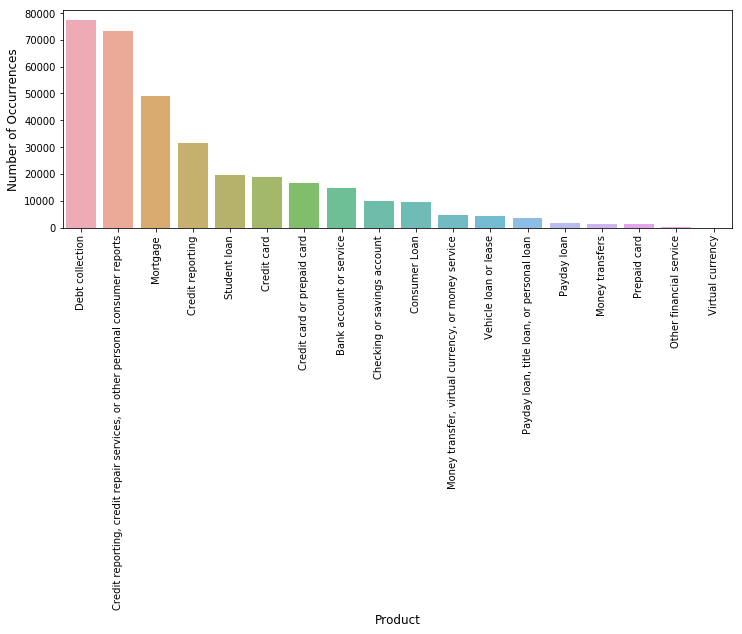

In [8]:
cnt_pro = df['Product'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [9]:
def print_complaint(index):
    example = df[df.index == index][['narrative', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])


print_complaint(12)

this account is old, and should have been removed. it appears to have been transferred several times, they mention continue to update as un paid on my credit file, what for the rest of my life. another threat involving my way of living. amazing how I 'm following the law and getting robbed and bullied, controlled.
Product: Debt collection


In [10]:
print_complaint(20)

I transferred ( Wire Transfer ) money from XXXX XXXX XXXX on XXXX/XXXX/XXXX to Coinbase, Inc amount of XXXX USD. The Money was transferred same day from my bank account. I have contacted the recipient through there web site asking about the status of the transfer. I have requested them 5 to 6 times in past 5 days. They responded for my 1st request asking the Federal Reference number for the transfer. I sent the required details, but till date no response from them. The CaseID with CoinBase Inc is XXXX. Attaching the Email exchange and Bank Statement ( To Confirm the money was transferred from my account ).
Product: Money transfer, virtual currency, or money service


In [11]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['narrative'] = df['narrative'].apply(cleanText)

In [12]:
train, test = train_test_split(df, test_size=0.3, random_state=42)
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/zachlim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['narrative']), tags=[r.Product]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['narrative']), tags=[r.Product]), axis=1)

In [15]:
train_tagged.values[30]

TaggedDocument(words=['some', 'one', 'from', 'my', 'pnc', 'business', 'checking', 'account', 'initiated', 'ach', 'transaction', 'for', 'for', 'si', 'days', 'and', 'transferred', 'more', 'than', '30000.00', 'from', 'my', 'business', 'account', 'company', 'who', 'took', 'out', 'the', 'money', 'named', 'some', 'company', 'originated', 'these', 'translations', 'on', '//', '--', '5000.00', 'on', '//', '--', '5000.00', 'on', '//', '--', '5000.00', 'on', '//', '--', '5000.00', 'on', '//', '--', '5000.00', 'on', '//', '--', '5000.00', 'total', '30000.00', 'was', 'taken', 'out', 'from', 'our', 'pnc', 'bank', 'account', 'without', 'our', 'permission', 'when', 'ach', 'transaction', 'initiated', 'we', 'were', "n't", 'aware', 'and', 'there', 'was', 'no', 'permission', 'given', 'to', 'the', 'company', 'pnc', 'bank', 'even', 'did', "n't", 'care', 'to', 'check', 'the', 'permission', 'or', 'never', 'called', 'us', 'to', 'get', 'permission', 'to', 'authorize', 'these', 'transactions', 'when', 'we', 'che

### Distributed Bag of Words (DBOW)
DBOW is the doc2vec model analogous to Skip-gram model in word2vec. The paragraph vectors are obtained by training a neural network on the task of predicting a probability distribution of words in a paragraph given a randomly-sampled word from the paragraph.

We will vary the following parameters:

If dm=0, distributed bag of words (PV-DBOW) is used; if dm=1,‘distributed memory’ (PV-DM) is used.
300- dimensional feature vectors.
min_count=2, ignores all words with total frequency lower than this.
negative=5 , specifies how many “noise words” should be drawn.
hs=0 , and negative is non-zero, negative sampling will be used.
sample=0 , the threshold for configuring which higher-frequency words are randomly down sampled.
workers=cores , use these many worker threads to train the model (=faster training with multicore machines).

In [16]:
import multiprocessing
cores = multiprocessing.cpu_count()

### Building a Vocabulary

In [17]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 236628/236628 [00:00<00:00, 2741002.97it/s]


In [18]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 236628/236628 [00:00<00:00, 2873724.96it/s]


CPU times: user 37min 42s, sys: 54.7 s, total: 38min 36s
Wall time: 13min 40s


### Building final vector feature

In [19]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

### Train the Logistic Regression Classifier.

In [21]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.6724483054440752
Testing F1 score: 0.6558325375694025


### Distributed Memory (DM)
<br>Distributed Memory (DM) acts as a memory that remembers what is missing from the current context — or as the topic of the paragraph. While the word vectors represent the concept of a word, the document vector intends to represent the concept of a document. We again instantiate a Doc2Vec model with a vector size with 300 words and iterating over the training corpus 30 times.

In [23]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 236628/236628 [00:00<00:00, 2554434.51it/s]


In [24]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 236628/236628 [00:00<00:00, 2950835.06it/s]


CPU times: user 1h 2min 50s, sys: 2min 5s, total: 1h 4min 56s
Wall time: 22min 39s


y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

### Model Pairing
According to Gensim doc2vec tutorial on the IMDB sentiment data set, combining a paragraph vector from Distributed Bag of Words (DBOW) and Distributed Memory (DM) improves performance. We will follow, pairing the models together for evaluation.

First, we delete temporary training data to free up RAM.

In [27]:
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [30]:
# concatenate 2 models
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [31]:
# Building feature vectors.
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [33]:
# Train the Logistic Regression

y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.6816483093883428
Testing F1 score: 0.6679105135237989


The result improved by 1%.

For this article, I used training set to train doc2vec, however, in Gensim’s tutorial, the whole data set was used for training, I tried that approach, using the whole data set to train doc2vec classifier for our consumer complaint classification, I was able to achieve 70% accuracy. You can find that notebook here, it is a little different approach.